In [1]:
import pandas as pd
import numpy as np

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set(rc={'figure.figsize': (9,9)})

In [4]:
events_data = pd.read_csv('event_data_train.csv')
submissions_data = pd.read_csv('submissions_data_train.csv')
events_data.head(10)

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632
5,32811,1434340895,passed,17632
6,32929,1434340921,discovered,17632
7,32929,1434340921,viewed,17632
8,32929,1434340939,started_attempt,17632
9,32929,1434340944,passed,17632


In [6]:
events_data.action.unique() #показывает все уникальные данные в столбике action


array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [7]:
submissions_data['date'] = pd.to_datetime(submissions_data.timestamp, unit='s')
events_data['date'] = pd.to_datetime(events_data.timestamp, unit='s')


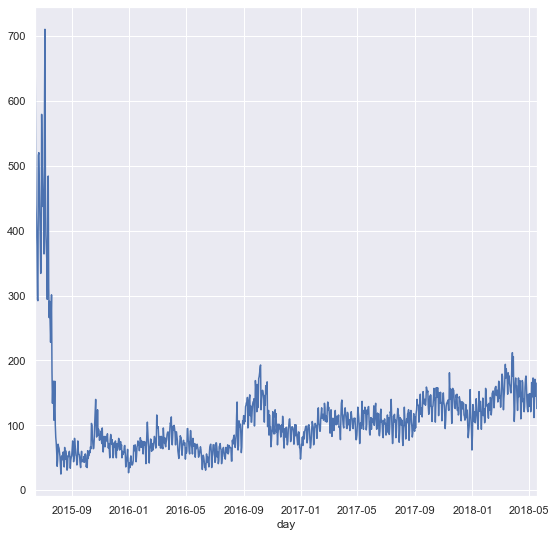

In [32]:
submissions_data['day'] = submissions_data.date.dt.date
events_data['day'] = events_data.date.dt.date
events_data.groupby('day').user_id.nunique().plot()


In [33]:
# events_data[events_data.action=='passed'].groupby('user_id', as_index=False)\
#     .agg({'step_id': 'count'}).rename(columns={'step_id': 'passed_step'}).passed_step.hist()

In [34]:
user_events_data = events_data.pivot_table(index='user_id', columns='action', 
                         values='step_id', aggfunc='count',
                         fill_value=0).reset_index()

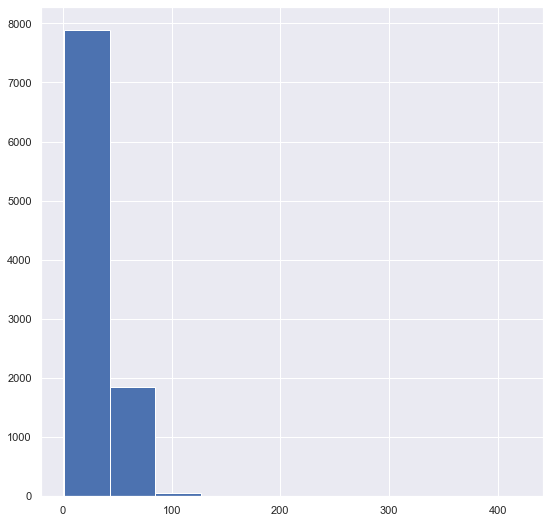

In [35]:
submissions_data[submissions_data.submission_status=='correct'].groupby('user_id')\
    .agg({'step_id': 'count'}).reset_index().step_id.hist()

In [36]:
 
user_scores= submissions_data.pivot_table(index='user_id', columns='submission_status', 
                             values='step_id', aggfunc='count',
                             fill_value=0).reset_index()
user_scores.head()

submission_status,user_id,correct,wrong
0,2,2,0
1,3,29,23
2,5,2,2
3,8,9,21
4,14,0,1


In [37]:
gap_data = events_data[['user_id', 'day', 'timestamp']].drop_duplicates(subset=['user_id', 'day'])\
    .groupby('user_id')['timestamp'].apply(list).apply(np.diff).values
gap_data = pd.Series(np.concatenate(gap_data, axis=0))

In [38]:
gap_data= gap_data / (24 *60*60)

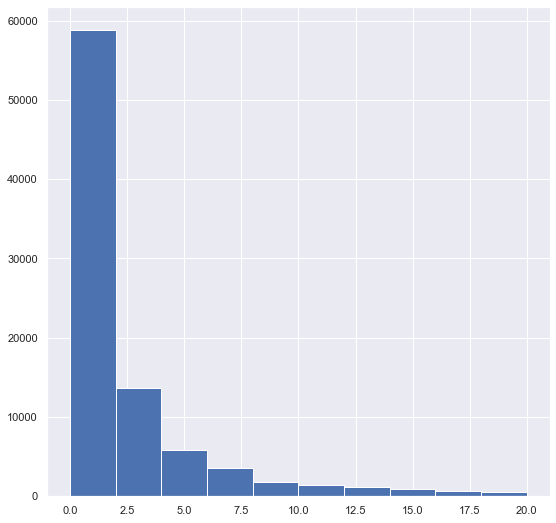

In [39]:
gap_data[gap_data<20].hist()

In [40]:
gap_data.quantile(0.90)
now = 1526772811
drop_out_threshold =  30*24*60*60

In [41]:
user_data = events_data.groupby('user_id', as_index=False).agg({'timestamp':'max'}).rename(columns={'timestamp':'last_timestamp'})
user_data['is_gone_user']= (now-user_data.last_timestamp) > drop_out_threshold
user_data.head()

,user_id,last_timestamp,is_gone_user
0,1,1472827464,True
1,2,1519226966,True
2,3,1444581588,True
3,5,1499859939,True
4,7,1521634660,True


In [42]:
user_data = user_data.merge(user_scores, on='user_id', how='outer')
user_data = user_data.fillna(0)

In [43]:
user_data = user_data.merge(user_events_data, on='user_id', how='outer')

events_data.head()

,step_id,timestamp,action,user_id,date,day
0,32815,1434340848,viewed,17632,2015-06-15 04:00:48,2015-06-15
1,32815,1434340848,passed,17632,2015-06-15 04:00:48,2015-06-15
2,32815,1434340848,discovered,17632,2015-06-15 04:00:48,2015-06-15
3,32811,1434340895,discovered,17632,2015-06-15 04:01:35,2015-06-15
4,32811,1434340895,viewed,17632,2015-06-15 04:01:35,2015-06-15


In [44]:
user_days = events_data.groupby('user_id').day.nunique().to_frame().reset_index()


In [45]:
user_data = user_data.merge(user_days, on='user_id', how='outer')
user_data.head()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
0,1,1472827464,True,0.0,0.0,1,0,0,1,1
1,2,1519226966,True,2.0,0.0,9,9,2,10,2
2,3,1444581588,True,29.0,23.0,91,87,30,192,7
3,5,1499859939,True,2.0,2.0,11,11,4,12,2
4,7,1521634660,True,0.0,0.0,1,1,0,1,1


In [46]:
user_data['passed_course'] = user_data.passed > 170

In [48]:
user_data.groupby('passed_course').count()

,user_id,last_timestamp,is_gone_user,correct,wrong,discovered,passed,started_attempt,viewed,day
passed_course,,,,,,,,,,
False,17809,17809,17809,17809,17809,17809,17809,17809,17809,17809
True,1425,1425,1425,1425,1425,1425,1425,1425,1425,1425
